# Customer Lifetime Value Analysis

---------------

### [Reading pkl and Loading Packages](#intro)
   - Reading pkl
   - Loading packages

### [Data Preparation](#prep)
   - Creating frequency, recency, age summary
   
### [Frequency/Recency Analysis w the BG/NBD model](#bg/nbd)
- Analyzing customers
- Predicting probabilities of customer returns

### [Assessing Model Fit](#fit)
- Comparing predictions with hold-out model

### [Customer predictions](#pred)
- probability of customer buying in period x
- probability of customer being alive

### [Estimating average transaction value](#exp)

### [CLV calculation using DCF](#clv)



----------------


<a id='intro'></a>
Reading in data & loading packages

In [2]:
%matplotlib inline
import scipy.stats as stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [3]:
df = pd.read_pickle('/Users/lukas/Desktop/CapstoneLukas/NOSO/Jialan_Zhu/USJH_order_dataset_orderUnit.pkl')

In [4]:
df.columns

Index(['Name', 'Financial Status', 'Paid at', 'Fulfillment Status',
       'Accepts Marketing', 'Currency', 'Subtotal', 'Shipping', 'Taxes',
       'Total', 'Discount Code', 'Discount Amount', 'Shipping Method',
       'Created at', 'Lineitem fulfillment status', 'Shipping Street',
       'Shipping Address1', 'Shipping Address2', 'Shipping Company',
       'Shipping City', 'Shipping Zip', 'Shipping Province',
       'Shipping Country', 'Notes', 'Note Attributes', 'Cancelled at',
       'Payment Method', 'Refunded Amount', 'Vendor', 'Tags', 'Risk Level',
       'Source', 'Color ', 'item_quantity'],
      dtype='object')

In [5]:
df['Shipping Company']

0                              US JEWELRY HOUSEW
1                              US JEWELRY HOUSEW
2                              US JEWELRY HOUSEW
3                                La Bella Bijoux
4                              US JEWELRY HOUSEW
5                                    Kids N more
6                                       Lillians
7                         Hello Shell Fundrasing
8                                        Ragazza
9                               Golden Rule, Inc
10                        stef's salon & spa llc
11                          impressions by tracy
12                             The Hidden Closet
13                           Somerly Hair Studio
14                                  Ruby Blooms 
15                                   Crimzonrose
16                          Eloquii Design, Inc.
17                        Statement Accessories 
18                               The Vanity Room
19                                     JKL SALON
20                  

In [6]:
df.columns

Index(['Name', 'Financial Status', 'Paid at', 'Fulfillment Status',
       'Accepts Marketing', 'Currency', 'Subtotal', 'Shipping', 'Taxes',
       'Total', 'Discount Code', 'Discount Amount', 'Shipping Method',
       'Created at', 'Lineitem fulfillment status', 'Shipping Street',
       'Shipping Address1', 'Shipping Address2', 'Shipping Company',
       'Shipping City', 'Shipping Zip', 'Shipping Province',
       'Shipping Country', 'Notes', 'Note Attributes', 'Cancelled at',
       'Payment Method', 'Refunded Amount', 'Vendor', 'Tags', 'Risk Level',
       'Source', 'Color ', 'item_quantity'],
      dtype='object')

In [7]:
#taking shipping street as customer id 
df2 = df[['Created at', 'Shipping Company']]

In [8]:
df2.head()

,Created at,Shipping Company
0,2015-10-27 16:16:00,US JEWELRY HOUSEW
1,2015-11-03 16:22:00,US JEWELRY HOUSEW
2,2015-11-03 16:31:00,US JEWELRY HOUSEW
3,2015-11-06 16:51:00,La Bella Bijoux
4,2015-11-06 18:09:00,US JEWELRY HOUSEW


### Data Preparation
<a id='prep'></a>



In [9]:
from lifetimes.utils import summary_data_from_transaction_data

In [10]:
summary = summary_data_from_transaction_data(df2, 'Shipping Company', 'Created at', observation_period_end='2018-07-16', freq= 'M')

In [11]:
summary.head()

,frequency,recency,T
Shipping Company,,,
Piercing Heaven,0.0,0.0,3.0
supreme,0.0,0.0,3.0
-,2.0,17.0,26.0
1 of a kind boutique,0.0,0.0,21.0
10 Hours of Fashion (Magic Show),0.0,0.0,16.0


**Explanation**:

- *Frequency*: Number of repeat purchases (Total no. of purchases -1)
- *T*: Age of customer (I specified the time unit to be 'M' for months)
- *Recency*: Age of customer when they made their last purchase (0 if one-time customer)

## Frequency/Recency Analysis w the BG/NBD model
<a id='bg/nbd'></a>



In [12]:
from lifetimes import BetaGeoFitter

In [13]:
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 1484 subjects, a: 0.68, alpha: 3.04, b: 2.98, r: 0.31>


In [14]:
bgf.save_model('bgf.pkl')

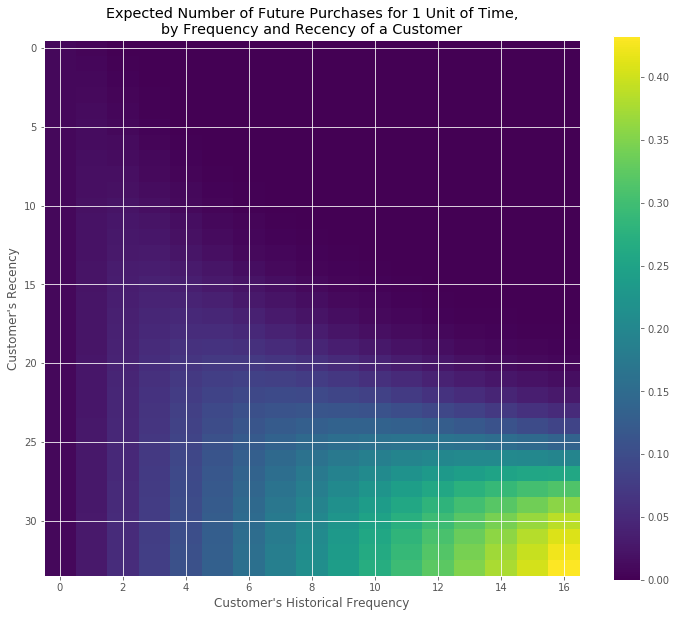

In [15]:
#plotting expected number of future purchases given frequency vs. recency
from lifetimes.plotting import plot_frequency_recency_matrix

plt.figure(figsize=(12,10))
fig = plot_frequency_recency_matrix(bgf)
fig

**What does this plot show?**

-> If a customer has bought ~18 times from USJH and their and their age at the latest purchase was slightly above 30, they are USJH's best customer

-> Fading tail shows that for customers that have bough around 5 times from USJH and their recency was between 20 and 25, they still might buy again but they also might be dead



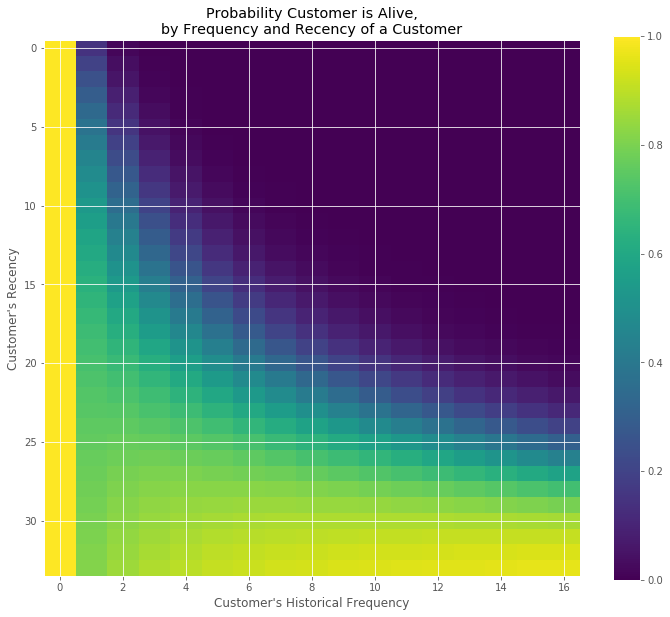

In [16]:
#plotting probability that customer is still alive given frequency vs. recency
from lifetimes.plotting import plot_probability_alive_matrix

plt.figure(figsize=(12,10))
plot_probability_alive_matrix(bgf)

In [18]:
#ranking customers from best to worst given their probability of buying in the next month
t = 1
summary['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, summary['frequency'], summary['recency'], summary['T'])
summary.sort_values(by='predicted_purchases').tail()

,frequency,recency,T,predicted_purchases
Shipping Company,,,,
DFTI Boutique,10.0,12.0,13.0,0.569567
F.A.F,10.0,12.0,13.0,0.569567
Love Carter,7.0,8.0,8.0,0.601848
EmmaChristians LLC,12.0,14.0,15.0,0.612153
Violet Boutique,9.0,9.0,9.0,0.712552


In [21]:
temp = pd.DataFrame(bgf.conditional_expected_number_of_purchases_up_to_time(t, summary['frequency'], summary['recency'], summary['T']))

In [22]:
temp['ID'] = temp.index

In [24]:
temp.columns = ['Probability', 'ID']

In [28]:
temp = temp.round(2)

In [30]:
temp.Probability = temp.Probability * 100

In [32]:
temp.Probability = temp.Probability.astype(int)

In [36]:
temp.to_csv('next_month.csv')

In [40]:
next_month = pd.read_csv('https://gist.githubusercontent.com/lksfr/4d3fa51162f9a881f27fe49616bb37b5/raw/2d0b0b1d540596312b17f767af747592e2ed5739/next_month.csv')

In [42]:
prob = next_month[next_month['ID']=='A Beautiful Touch']['Probability']

In [46]:
int(prob)

4

-> Customer "Violet Boutique" has the highest probability of purchasing next month

## Assessing model fit
<a id='fit'></a>



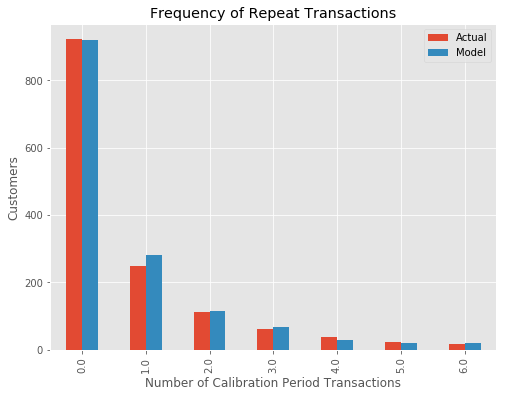

In [54]:
#comparing our data with artificially simulated data  with our fitted model’s parameters
from lifetimes.plotting import plot_period_transactions

plot_period_transactions(bgf, figsize=(8,6))

-> model seems to be relevant

## Dividing into calibration and holdout data set

In [55]:
from lifetimes.utils import calibration_and_holdout_data

summary_cal_holdout = calibration_and_holdout_data(df2, 'Shipping Company', 'Created at',
                                        calibration_period_end='2018-01-31',
                                        observation_period_end='2018-07-16', 
                                                   freq='M'
                                                  )   
print(summary_cal_holdout.head())

                                  frequency_cal  recency_cal  T_cal  \
Shipping Company                                                      
-                                           2.0         17.0   20.0   
1 of a kind boutique                        0.0          0.0   15.0   
10 Hours of Fashion (Magic Show)            0.0          0.0   10.0   
1986                                        0.0          0.0    9.0   
1989                                        0.0          0.0    7.0   

                                  frequency_holdout  duration_holdout  
Shipping Company                                                       
-                                               0.0                 6  
1 of a kind boutique                            0.0                 6  
10 Hours of Fashion (Magic Show)                0.0                 6  
1986                                            0.0                 6  
1989                                            0.0                 6 

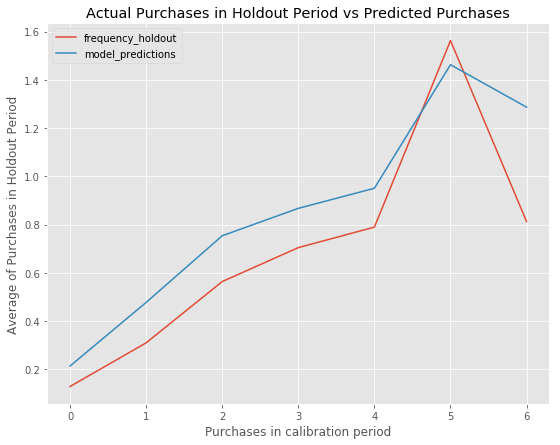

In [56]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])

plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout, figsize=(9,7))

## Predicting Probability of specific customer buying in X periods
<a id='intro'></a>

In [124]:
summary2 = summary
summary2['id'] = summary2.index

In [121]:
summary2.to_csv('summary2.csv')

In [126]:
#defining a function that returns the probability of customer x buying in n peridos
def customer_order_prob(name, periods=1):

   
    t = periods
    individual = summary2.loc[name]
    individual_id = summary2.loc[name].id
    probability = bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])
    return('The customer with ID \"' + individual_id + '\" will make {:.2f} repeat purchases over the course of '.format(probability) + str(periods) + ' months.')

In [127]:
#sample request
customer_order_prob('10 Hours of Fashion (Magic Show)', 6)

'The customer with ID "10 Hours of Fashion (Magic Show)" will make 0.10 repeat purchases over the course of 6 months.'

## Plot predicting probability of customer x being alive

In [147]:
df2.head()

,Created at,Shipping Company
0,2015-10-27 16:16:00,US JEWELRY HOUSEW
1,2015-11-03 16:22:00,US JEWELRY HOUSEW
2,2015-11-03 16:31:00,US JEWELRY HOUSEW
3,2015-11-06 16:51:00,La Bella Bijoux
4,2015-11-06 18:09:00,US JEWELRY HOUSEW


In [149]:
temp = pd.read_csv('https://gist.githubusercontent.com/lksfr/ae394805cb25c961e5284fd9215997a8/raw/a4ded8cda256058a7ee2de588eedef923a0e4066/df2.csv', index_col=False)
temp.head()

,Unnamed: 0,Created at,Shipping Company
0,0,2015-10-27 16:16:00,US JEWELRY HOUSEW
1,1,2015-11-03 16:22:00,US JEWELRY HOUSEW
2,2,2015-11-03 16:31:00,US JEWELRY HOUSEW
3,3,2015-11-06 16:51:00,La Bella Bijoux
4,4,2015-11-06 18:09:00,US JEWELRY HOUSEW


In [156]:
def alive_plotter(name, min_months_alive=5):   
    from lifetimes.plotting import plot_history_alive

  # summary2 = summary
  #  summary2['id'] = summary2.index

  #  individual_id = summary2.iloc[index].id
    
    months_since_birth = 5
    sp_trans = df2.loc[df2['Shipping Company'] == name]
    plt.figure(figsize=(12,10))
    plot_history_alive(bgf, months_since_birth, sp_trans, 'Created at')

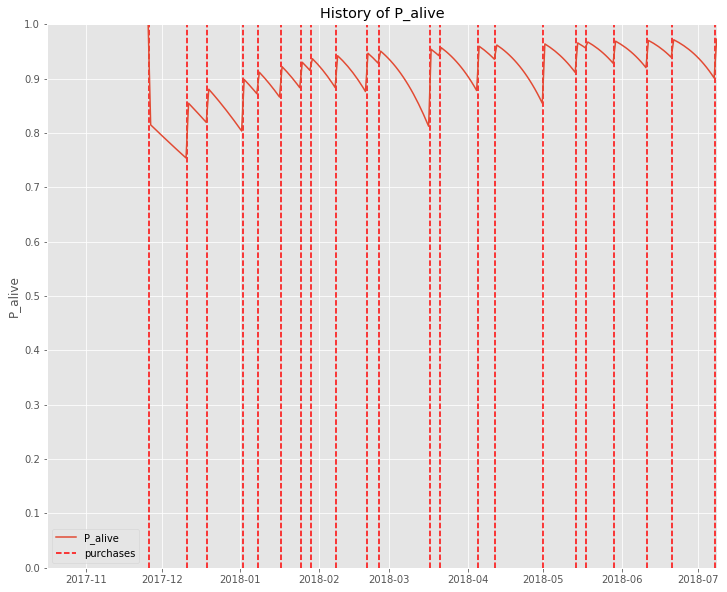

In [158]:
#address id equivalent here - put in any address/id to display graph
alive_plotter('Violet Boutique')

## Estimating CLV using Gamma-Gamma Model
<a id='exp'></a>

In [92]:
#creating a dataframe including the monetary value of each transaction
summary2 = summary_data_from_transaction_data(df, 'Shipping Company', 'Created at',monetary_value_col='Total', observation_period_end='2018-07-16', freq= 'M')

In [93]:
summary2.head()

,frequency,recency,T,monetary_value
Shipping Company,,,,
Piercing Heaven,0.0,0.0,3.0,0.000
supreme,0.0,0.0,3.0,0.000
-,2.0,17.0,26.0,108.275
1 of a kind boutique,0.0,0.0,21.0,0.000
10 Hours of Fashion (Magic Show),0.0,0.0,16.0,0.000


In [94]:
#filter summary to only include customers that have returned at least once
returning_customers_summary = summary2[summary2['frequency']>0]

returning_customers_summary.head()

,frequency,recency,T,monetary_value
Shipping Company,,,,
-,2.0,17.0,26.0,108.275000
100 Capitol Yards,1.0,4.0,5.0,30.540000
33 STAR,1.0,13.0,20.0,308.500000
4th Street Boutique,3.0,24.0,26.0,337.973333
7th Street Surf Shop,4.0,5.0,15.0,346.600000


In [95]:
#Gamma-Gamma model relies on assumption that monetary value and purchase frequency are independent
indep_test = returning_customers_summary[['monetary_value', 'frequency']]

In [96]:
#correlation
indep_test.corr()

,monetary_value,frequency
monetary_value,1.000000,0.051167
frequency,0.051167,1.000000


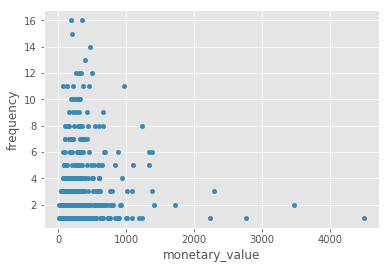

In [97]:
indep_test.plot(x='monetary_value', y='frequency', kind='scatter')

In [98]:
#fitting model
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 563 subjects, p: 2.08, q: 3.10, v: 328.65>


**Estimating average transaction value**

In [99]:
CoExAvPr = pd.DataFrame(ggf.conditional_expected_average_profit(
        summary2['frequency'],
        summary2['monetary_value']
    ))

In [100]:
CoExAvPr.columns = ['conditional_expected_average_profit']

In [101]:
CoExAvPr.sort_values(by='conditional_expected_average_profit', ascending=False).head(10)

,conditional_expected_average_profit
Shipping Company,
US Jewelry House,2424.253793
Gwynnie Bee,2406.196684
MAM CREACIÓNES LTDA,1798.799191
LILYHOCKCREATIONS C/O LERNER,1544.791381
Coral,1276.686997
Mari Caron Maison De Paris,1259.057698
US Jewelry House of Florida,1225.838216
Walnut Street Theatre,1194.651172
THREAD,1170.794895


**Calculating total CLV using Discounted Cash Flow Method (DCF)**
<a id='clv'></a>

In [102]:
# refit the BG model to the summary_with_money_value dataset
bgf.fit(summary2['frequency'], summary2['recency'], summary2['T'])

clv = pd.DataFrame(ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    summary2['frequency'],
    summary2['recency'],
    summary2['T'],
    summary2['monetary_value'],
    time=12, # months
    discount_rate=0.01 # monthly discount rate ~ 12.7% annually
))

In [103]:
clv.sort_values(by='clv', ascending=False).head(10)

,clv
Shipping Company,
Front and Company,45518.805426
MAM CREACIÓNES LTDA,39091.073238
Violet Boutique,37467.152461
SHELALA,36401.711677
K and M Accessories,36323.406441
Walnut Street Theatre,29200.318348
The Rabbit Hole,26478.308647
People People,26360.902250
7th street surf shop,25299.573070


In [104]:
#creating a df containing both percentile and our target group assignment
percentile = clv.clv.rank(pct=True)

In [105]:
clv_percentile = pd.concat([clv, percentile.rename('Percentile')], axis=1)

In [106]:
clv_percentile.sort_values('Percentile', ascending=False)

,clv,Percentile
Shipping Company,,
Front and Company,45518.805426,1.000000
MAM CREACIÓNES LTDA,39091.073238,0.999326
Violet Boutique,37467.152461,0.998652
SHELALA,36401.711677,0.997978
K and M Accessories,36323.406441,0.997305
Walnut Street Theatre,29200.318348,0.996631
The Rabbit Hole,26478.308647,0.995957
People People,26360.902250,0.995283
7th street surf shop,25299.573070,0.994609


In [107]:
lis = list(clv_percentile.Percentile)

In [108]:
lis

[0.6694743935309974,
 0.6694743935309974,
 0.6030997304582211,
 0.19305929919137466,
 0.306266846361186,
 0.7419137466307277,
 0.7126010781671159,
 0.33389487870619944,
 0.36725067385444743,
 0.23517520215633422,
 0.7284366576819407,
 0.523921832884097,
 0.9043126684636119,
 0.6954177897574124,
 0.9946091644204852,
 0.306266846361186,
 0.6263477088948787,
 0.17351752021563344,
 0.9831536388140162,
 0.6263477088948787,
 0.23517520215633422,
 0.9285714285714286,
 0.6694743935309974,
 0.27088948787061995,
 0.4528301886792453,
 0.306266846361186,
 0.7126010781671159,
 0.523921832884097,
 0.33389487870619944,
 0.9487870619946092,
 0.9737196765498652,
 0.306266846361186,
 0.018194070080862535,
 0.3746630727762803,
 0.6694743935309974,
 0.7870619946091644,
 0.0330188679245283,
 0.6263477088948787,
 0.007412398921832884,
 0.10849056603773585,
 0.24966307277628033,
 0.7634770889487871,
 0.8106469002695418,
 0.9137466307277629,
 0.23517520215633422,
 0.09299191374663072,
 0.23517520215633422,
 0

In [109]:
new_lis = []

for el in lis:
    
    if el >= 0.75:
        new_lis.append('Gold')
    elif el >= 0.5 and el < 0.75:
        new_lis.append('Silver')
    elif el >= 0.25 and el < 0.5:
        new_lis.append('Bronze')
    elif el >= 0 and el < 0.25:
        new_lis.append('Low Priority')
    else:
        print('Error')

In [110]:
clv_percentile['ID'] = clv.index

In [111]:
clv_percentile.reset_index(drop=True, inplace=True)

In [112]:
target = pd.Series(new_lis)
target = target.astype(str)
target.tail()

1479          Bronze
1480          Silver
1481    Low Priority
1482    Low Priority
1483          Bronze
dtype: object

In [113]:
clv_percentile.tail()

,clv,Percentile,ID
1479,1176.024507,0.452830,winks
1480,1612.222801,0.626348,wwl
1481,735.250864,0.173518,you wish it
1482,735.250864,0.173518,your family jeweler
1483,983.957930,0.367251,zirconia


In [114]:
final_clv = pd.concat([clv_percentile, target], axis=1)

In [115]:
final_clv = final_clv[['ID', 'clv', 'Percentile', 0]]
final_clv.columns = ['ID', 'CLV', 'Percentile', 'Target_Group']

In [116]:
final_clv = final_clv.round(2)

In [117]:
final_clv.head()

,ID,CLV,Percentile,Target_Group
0,Piercing Heaven,1757.09,0.67,Silver
1,supreme,1757.09,0.67,Silver
2,-,1519.04,0.60,Silver
3,1 of a kind boutique,755.69,0.19,Low Priority
4,10 Hours of Fashion (Magic Show),881.44,0.31,Bronze


In [122]:
final_clv.to_csv('CLV.csv')